In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
df_apple_spain = pd.read_csv('apple_spain.csv')

In [3]:
df_apple_spain = df_apple_spain.rename(columns={'yield': 'fruit_set'})

In [6]:
# Remove rows where 'yield' column has missing values
df_apple_spain = df_apple_spain.dropna(subset=['fruit_set'])


In [4]:
# Select only the numerical columns for correlation
numerical_df_apple_spain = df_apple_spain.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numerical_df_apple_spain.corr()

# Extract the correlations of 'fruit_set' with other columns
apple_spain_yield_corr = corr['fruit_set']

# Display the correlations
print('Fruit Set')
print(apple_spain_yield_corr)



Fruit Set
Unnamed: 0                            0.341208
fruit_set                             1.000000
yield_treatments_pollen_supplement    0.799522
fruits_per_plant                     -0.172551
seeds_per_fruit                       0.093084
observed_pollinator_richness         -0.103098
abundance                            -0.201176
ab_honeybee                          -0.020596
ab_bombus                            -0.235670
ab_wildbees                          -0.152310
ab_syrphids                          -0.156391
ab_humbleflies                        0.270056
ab_other_flies                       -0.107205
ab_beetles                           -0.114080
ab_lepidoptera                       -0.064157
ab_nonbee_hymenoptera                -0.221504
ab_others                            -0.133206
visitation_rate                       0.244306
visit_honeybee                        0.214151
visit_bombus                         -0.206704
visit_wildbees                        0.180469
vis

Linear regression: Predicting fruit set based on several features individually

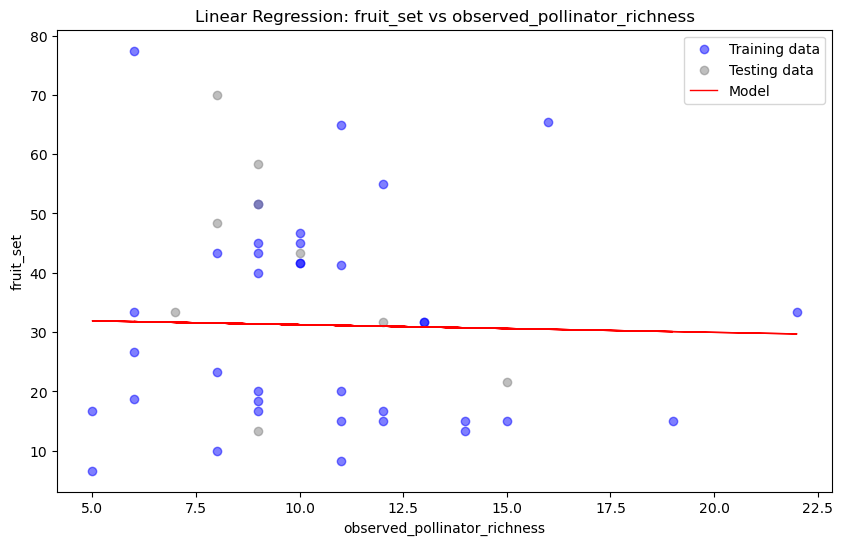

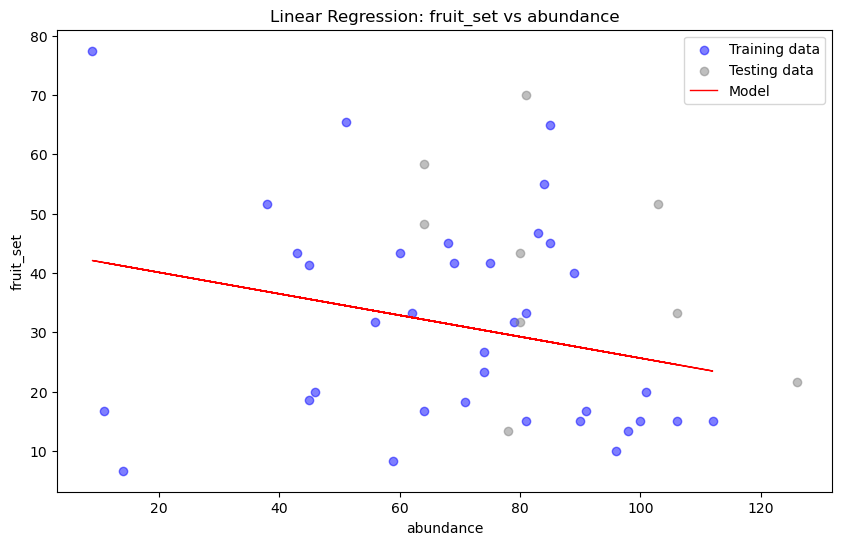

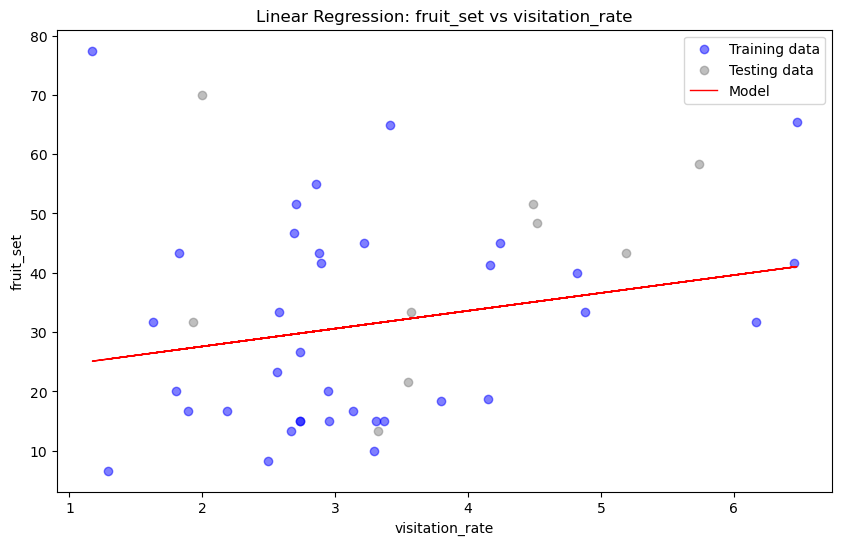

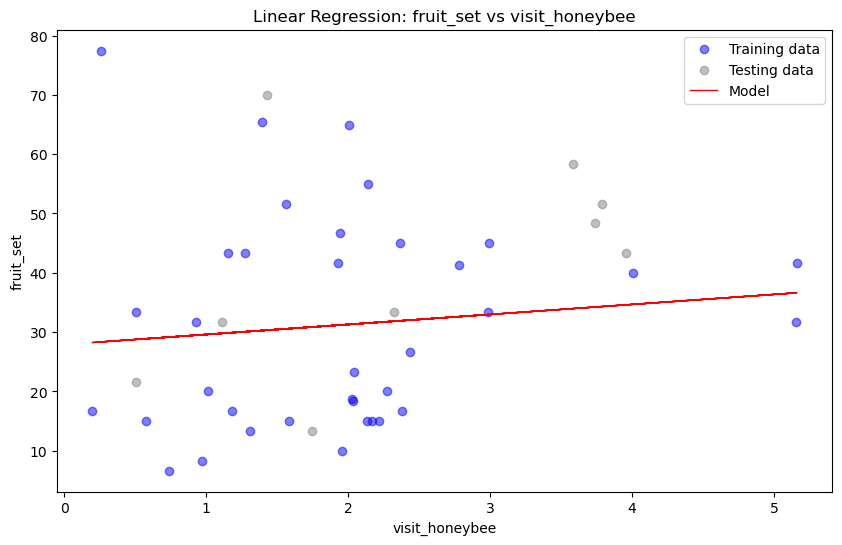

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,observed_pollinator_richness,-0.129,32.55,15.99,384.01,19.60,-0.33
1,abundance,-0.181,43.73,16.90,430.46,20.75,-0.49
2,visitation_rate,3.006,21.58,14.66,347.67,18.65,-0.20
3,visit_honeybee,1.689,27.92,14.69,345.10,18.58,-0.20


In [7]:
def test_features(df, features, target):
    """
    Test multiple features for linear regression models, visualize the regression for each feature
    with both training and testing data.
    
    Parameters:
    - df: DataFrame containing the dataset.
    - features: List of feature names to test.
    - target: Name of the target variable.
    
    Returns:
    - A DataFrame with the results of the analysis for each feature.
    """
    # Initialize an empty list to store results
    results = []
    
    for feature in features:
        # Prepare the data
        X = df[[feature]]  # Feature matrix
        y = df[target]  # Target variable
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
        
        # Create and train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict target values for both training and testing set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate evaluation metrics using test set
        mae = round(mean_absolute_error(y_test, y_pred_test), 2)
        mse = round(mean_squared_error(y_test, y_pred_test), 2)
        rmse = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
        R2 = round(r2_score(y_test, y_pred_test), 2)
        
        # Append the results
        results.append({
            'Feature': feature,
            'Coefficient': round(model.coef_[0], 3),
            'Intercept': round(model.intercept_, 2),
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': R2
        })
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training data')
        plt.scatter(X_test, y_test, color='gray', alpha=0.5, label='Testing data')
        plt.plot(X_train, y_pred_train, 'r-', linewidth=1, label='Model')
        plt.title(f'Linear Regression: {target} vs {feature}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.legend()
        plt.show()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
features_to_test = ['observed_pollinator_richness', 'abundance', 'visitation_rate', 'visit_honeybee']
target_column = 'fruit_set'
results_df = test_features(df_apple_spain, features_to_test, target_column)

display(results_df)


Multiple linear regression

In [8]:
# Prepare the data
features = ['observed_pollinator_richness','abundance', 'visitation_rate', 'visit_honeybee']
X = df_apple_spain[features]  # Feature matrix
y = df_apple_spain['fruit_set']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict 'yield2' values for the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = round(mean_absolute_error(y_test, y_pred),2)
mse = round(mean_squared_error(y_test, y_pred),2)
rmse = round(mean_squared_error(y_test, y_pred, squared=False),2)
R2 = round(r2_score(y_test, y_pred),2)

# Print the model coefficients and evaluation metrics
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared score:", R2)


Coefficients: [ 0.32755435 -0.29715551  2.4586244   0.89129885]
Intercept: 40.04329701664787
Mean Absolute Error: 15.09
Mean Squared Error: 281.53
Root Mean Squared Error: 16.78
R-squared score: -0.44


Random Forest

In [9]:
# Define your features and target variable
features = ['observed_pollinator_richness','abundance', 'visitation_rate', 'visit_honeybee']
X = df_apple_spain[features]
y = df_apple_spain['fruit_set']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 13.442347594308368
Mean Squared Error (MSE): 251.69888087164574
Root Mean Squared Error (RMSE): 15.865020670381925
R-squared (R2): -0.29035502219008347
